In [12]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.transforms as T

from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.models import resnet50
from torchmetrics.functional import accuracy

import pytorch_lightning as pl

In [13]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.5.1
numpy version: 1.23.4
seaborn version: 0.12.1
torch version: 1.13.0+cu116
pytorch ligthening version: 1.8.1


In [14]:
cancer_labels = pd.read_csv('./histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [15]:
np.random.seed(0)
train_imgs_orig = os.listdir("./histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
    selected_image_list.append(img)
len(selected_image_list)

10000

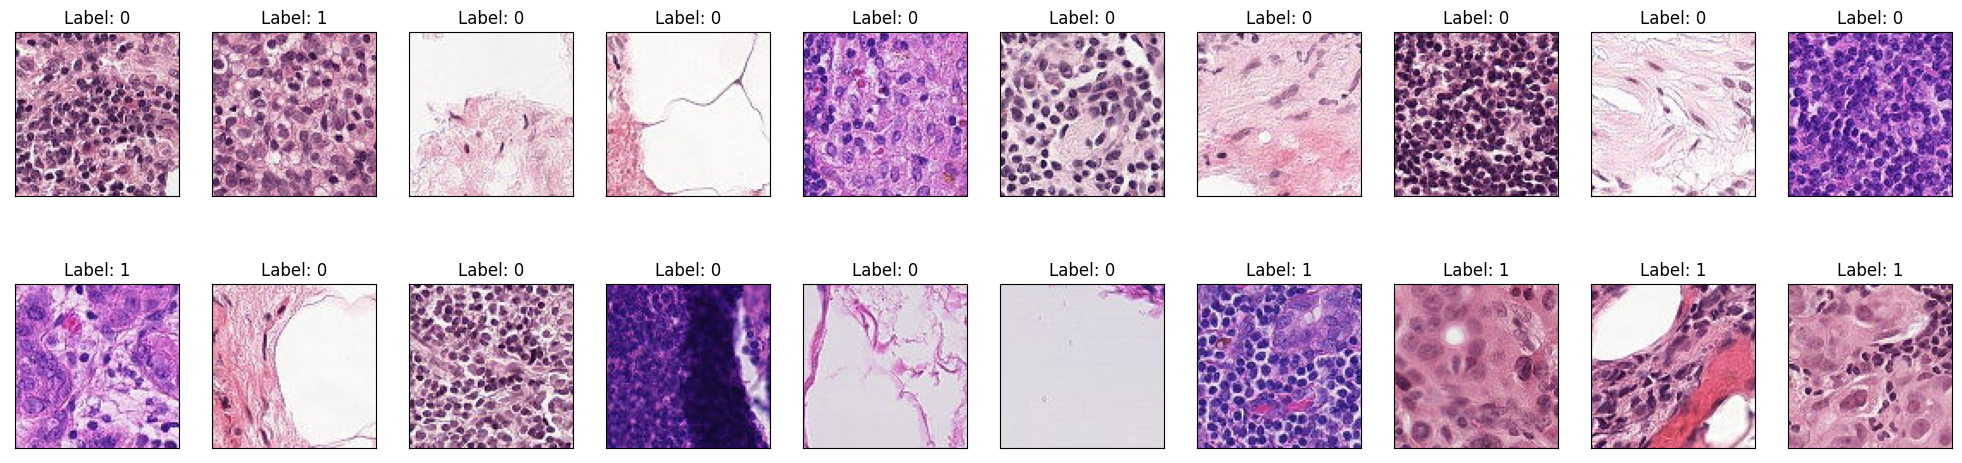

In [24]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("./histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [25]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [26]:
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [19]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,29badac58315e7f18769488186f83617b856691b,0
1,54e7d3df3dcaf8b7a46bb32f3900ea1e869ff339,0
2,4a0fc37995ecc5b3c5d587d0355292d040fe352d,1
3,02da2316e3845514d1543ebdb3b98cf129d8af3b,0
4,d0367dd00cf81095529aa56cf72a815e045c0268,0


In [20]:
img_class_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

In [21]:
data_T_train = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(),
    T.ToTensor()
    ])

data_T_test = T.Compose([
    T.Resize(224),
    T.ToTensor()
    ])

In [22]:
class LoadCancerDataset(Dataset):
    def __init__(self, datafolder, transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]
        

    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels_dict[img_name_short]
        return image, label

In [27]:
os.mkdir('./histopathologic-cancer-detection/cancer_train_dataset')
for fname in cancer_train_idx:
  src = os.path.join('./histopathologic-cancer-detection/train', fname)
  dst = os.path.join('./histopathologic-cancer-detection/cancer_train_dataset', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("./histopathologic-cancer-detection/cancer_train_dataset")))

No. of images in downsampled training dataset:  7851


In [28]:
os.mkdir('./histopathologic-cancer-detection/cancer_test_dataset')
for fname in cancer_train_idx:
  src = os.path.join('./histopathologic-cancer-detection/train', fname)
  dst = os.path.join('./histopathologic-cancer-detection/cancer_test_dataset', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("./histopathologic-cancer-detection/cancer_test_dataset")))

No. of images in downsampled training dataset:  7851


In [30]:
cancer_train_set = LoadCancerDataset(datafolder='./histopathologic-cancer-detection/cancer_train_dataset', transform=data_T_train, labels_dict=img_class_dict)
cancer_test_set = LoadCancerDataset(datafolder='./histopathologic-cancer-detection/cancer_test_dataset', transform=data_T_test, labels_dict=img_class_dict)

In [31]:
batch_size = 128
cancer_train_dataloader = DataLoader(cancer_train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
cancer_test_dataloader = DataLoader(cancer_test_set, batch_size, num_workers=2, pin_memory=True)

In [32]:
resnet50(pretrained=True)

/home/sd/works/practice-torch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sd/works/practice-torch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/sd/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [33]:
class CancerImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        
        self.pretrain_model = resnet50(pretrained=True)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False

        self.pretrain_model.fc = nn.Linear(2048, 2)

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        preds = torch.argmax(outputs, dim=1)
        train_accuracy = accuracy(preds, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, 'train_accuracy': train_accuracy}
        

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_accuracy = accuracy(preds, targets)
        loss = self.loss(outputs, targets)
        # self.log('test_accuracy', test_accuracy, prog_bar=True)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def test_epoch_end(self, outputs):
        test_outs = []
        for test_out in outputs:
            out = test_out['test_accuracy']
            test_outs.append(out)
        total_test_accuracy = torch.stack(test_outs).mean()
        self.log('total_test_accuracy', total_test_accuracy, on_step=False, on_epoch=True)
        return total_test_accuracy

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params, lr = self.learning_rate)
        return optimizer

In [34]:
model = CancerImageClassifier()
trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model, cancer_train_dataloader)

/home/sd/works/practice-torch/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | loss           | CrossEntropyLoss | 0     
1 | pretrain_model | ResNet           | 23.5 M
----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model pa

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [35]:
ckpt_dir = "./histopathologic-cancer-detection/transfer_learning"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)
model = CancerImageClassifier()
trainer = pl.Trainer(default_root_dir=ckpt_dir, gpus=-1,
                        # progress_bar_refresh_rate=30,
                        callbacks=[ckpt_callback],
                        log_every_n_steps=30,
                        max_epochs=10)
trainer.fit(model, train_dataloaders=cancer_train_dataloader)

/home/sd/works/practice-torch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sd/works/practice-torch/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/sd/works/practice-torch/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
GP

Training: 0it [00:00, ?it/s]